In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft

expts = ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]
client = Client(threads_per_worker=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38311,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:40119,Total threads: 4
Dashboard: /proxy/34175/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43507,


# Create a "budget" for the wave energy in a given region

Following the method of Klymak 2016, we'll make a budget of the M2 energy about the slope. I see it as having two options: Focus just on M2 in total, or the baroclinic M2 as in their paper. The former would look like:

$\large \frac{dE_{M2}}{dt} \sim \sum^N_n \int\int_A F_n \cdot dA + \int\int_A F_{BT} \cdot dA + R $ 

$\large \frac{dE_{BC}}{dt} \sim \sum^N_n \int\int_A F_n \cdot dA + C +  R $

Where $C$ is the barotropic to baroclinic conversion term: 

$\large C = \int^0_H \rho' g \nabla_h \cdot ((H + z) u) dz $ 

and $R$ is the residual containing all the other stuff. This *other stuff* will mostly be the interaction terms that bring the wave energy from M2 to other temporal frequencies as well as dissipation.

### Other options to extend this:

1. We could include the crappy dissipation term, filtered temporally to apply only to the M2 velocities. This seems to give values of ~mW/m2 around the shelf which might not do a lot to the energy balance
2. Cross scale transfer could give an idea of how much energy is going to different temporal frequencies

### Implementation:

Rather than computing temporal derivatives, we integrate the whole budget in time. Then we compare the change in E on the left with the cumulative integral of the quantities on the right.

# First, save timeseries of energy, energy flux and conversion


In [ ]:
tmpstorage = os.getenv('PBS_JOBFS')
tmpstorage = "/scratch/nm03/ab8992/test_budget"
outputdir = "/scratch/nm03/ab8992/test_budget/outputs"
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

# Modified from preprocess bulk, removed time means and dissipation stuff

def save_temporary(expt,t0,outputdir):
    """
    Open all the datasets that we need for this experiment. Save some of the simple stuff, and save the modal decompossitions to temporary storage chunked by mode for further processing.
    """
    with (
            xr.open_mfdataset(f"/g/data/nm03/ab8992/postprocessed/{expt}/bandpassed/t0-{t0}/Filtered*.nc",decode_times = False) as filtered,
            xr.open_dataset(f"/g/data/nm03/ab8992/postprocessed/{expt}/vertical_eigenfunctions/vmode-t0-{t0}.nc",decode_times = False,chunks = {"mode":1}).isel(zl = slice(0,96)) as vmodes,
            tt.collect_data(expt,rawdata=["u","v"],timerange = (filtered.time.values[0],filtered.time.values[-1])).isel(zl = slice(0,96)) as raw

    ):
        # os.remove(f"{tmpstorage}/*.nc")
        vmodes = vmodes.assign_coords({"zl":filtered.zl})
        ymin = vmodes.yb[0].values - 0.0001 ## This ensures random numerical changes of 1e-16 to axis values don't cause issues... 
        ymax = vmodes.yb[-1].values + 0.0001
        raw = raw.sel(yb = slice(ymin,ymax)).assign_coords(vmodes.isel(mode = 0).coords).drop_vars(["lat","lon"])
        filtered = filtered.sel(yb = slice(ymin,ymax)).assign_coords(vmodes.isel(mode = 0).coords)


        ## Here all variables are dask arrays. One by one, compute what we want and save to PBS temporart storage 

        for i in range(len(vmodes.mode.values)):
            print("Saving mode ",i)
            (vmodes.U * filtered.u).fillna(0).integrate("zl").rename("u").isel(mode = [i]).to_netcdf(f"{tmpstorage}/u_{i}.nc")
            (vmodes.U * filtered.v).fillna(0).integrate("zl").rename("v").isel(mode = [i]).to_netcdf(f"{tmpstorage}/v_{i}.nc")
            (vmodes.W * filtered.rho).fillna(0).integrate("zl").rename("rho").isel(mode = [i]).to_netcdf(f"{tmpstorage}/rho_{i}.nc")

        (vmodes.U * vmodes.W.cumsum("zl") * 9.8).fillna(0).integrate("zl").rename("p_coeff").to_netcdf(f"{tmpstorage}/p_coeff.nc")        


        ## While we have files open, might as well save some other simple stuff, like vorticity in top 20 layers, total raw KE, both bc and bt.
        print("Save vorticity...")

        ((raw.v.differentiate("xb") - raw.u.differentiate("yb")).fillna(0).mean("time").sel(zl = slice(0,200)).integrate("zl") / 200).rename("vorticity").to_netcdf(f"{outputdir}/raw_vorticity.nc")

        print("Save raw KE...")
        (raw.u**2 + raw.v**2).fillna(0).integrate("zl").rename("raw_KE_total").to_netcdf(f"{outputdir}/raw_ke_total.nc") ##Units of m^2/s^2. No density!
        print("Save raw KE bt...")
        (
            (raw.u.fillna(0).integrate("zl")**2 + raw.v.fillna(0).integrate("zl")**2) / raw.bathy
        ).rename("raw_KE_bt").to_netcdf(f"{outputdir}/raw_ke_bt.nc")


        print("Save filtered KE...")
        (filtered.u**2 + filtered.v**2).fillna(0).integrate("zl").rename("filtered_KE_total").to_netcdf(f"{outputdir}/filtered_ke_total.nc")
        print("Save filtered KE bt...")
        (
            (filtered.u.fillna(0).integrate("zl")**2 + filtered.v.fillna(0).integrate("zl")**2) / raw.bathy
        ).rename("filtered_KE_bt").to_netcdf(f"{outputdir}/filtered_ke_bt.nc")  

    return


def save_modal(outputdir):
    U = xr.open_mfdataset(f"{tmpstorage}/u_*.nc",combine = "by_coords",decode_times = False).u
    V = xr.open_mfdataset(f"{tmpstorage}/v_*.nc",combine = "by_coords",decode_times = False).v
    rho = xr.open_mfdataset(f"{tmpstorage}/rho_*.nc",combine = "by_coords",decode_times = False).rho # Rho here does have units of density, but values are small
    p_coeff = xr.open_mfdataset(f"{tmpstorage}/p_coeff.nc",combine = "by_coords",decode_times = False).p_coeff

    ## KE modal
    (U**2 + V**2).rename("KE_modal").to_netcdf(f"{outputdir}/ke_modal.nc") # units m^2/s^2

    ## EF modal
    (-1 * rho * U * p_coeff).rename("EF_alongbeam").to_netcdf(f"{outputdir}/ef_alongbeam.nc") # Units of W/m^2 since rho contains the density
    (-1 * rho * V * p_coeff).rename("EF_acrossbeam").to_netcdf(f"{outputdir}/ef_acrossbeam.nc")
        
    return 

save_temporary("full-20",22000,outputdir)
save_modal(outputdir)


loading u...	done.
loading v...	done.
Saving mode  0
Saving mode  1
Saving mode  2
Saving mode  3
Saving mode  4
Saving mode  5
Saving mode  6
Saving mode  7
Save vorticity...
Save raw KE...
Save raw KE bt...
Save filtered KE...
Save filtered KE bt...


In [2]:
outputdir = "/scratch/nm03/ab8992/test_budget/outputs"
expt,t0 = "full-20",22000

KE_modal = xr.open_dataset(f"{outputdir}/ke_modal.nc",decode_times = False)
EF_alongbeam = xr.open_dataset(f"{outputdir}/ef_alongbeam.nc",decode_times = False)
EF_acrossbeam = xr.open_dataset(f"{outputdir}/ef_acrossbeam.nc",decode_times = False)
rho = xr.open_mfdataset("/scratch/nm03/ab8992/test_budget/rho*",decode_times = False)
u = xr.open_mfdataset("/scratch/nm03/ab8992/test_budget/u*",decode_times = False)
v = xr.open_mfdataset("/scratch/nm03/ab8992/test_budget/v*",decode_times = False)
bathy = xr.open_dataset("/g/data/nm03/ab8992/outputs/full-20/bathy_transect.nc").sel(yb = slice(-120,120))
vmodes = xr.open_dataset(f"/g/data/nm03/ab8992/postprocessed/{expt}/vertical_eigenfunctions/vmode-t0-{t0}.nc").sel(yb = slice(-120,120))

uraw = tt.collect_data(expt,rawdata=["u","v"],timerange = (u.time.values[0],u.time.values[-1])).isel(zl = slice(0,96)).sel(yb = slice(-120,120))



loading u...	done.
loading v...	done.


In [38]:
def ConversionBTBC(rho,u,v,bathy,vmodes):
    W = ((vmodes.zl + bathy) * (u)).differentiate("xb") / 1e3 
    W += ((vmodes.zl + bathy) * (v)).differentiate("yb") / 1e3 

    C = (9.8 * W * vmodes.W).fillna(0).integrate("zl").load()
    C = (rho.rho * C).sum("mode")
    C /= bathy
    return C

Conversion = ConversionBTBC(rho,uraw.u,uraw.v ,bathy.depth,vmodes)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 151.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Exception ignored in: <function CachingFileManager.__del__ at 0x148b2e8ada20>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2627, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2590, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2034, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: Not 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 326.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


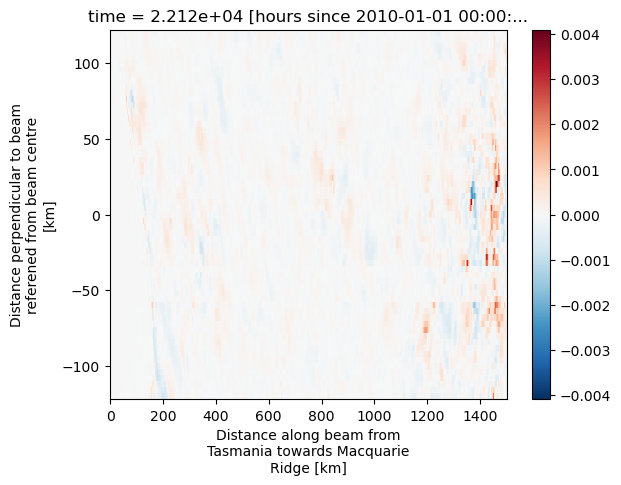

In [9]:
Conversion.isel(time = -1).plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 326.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


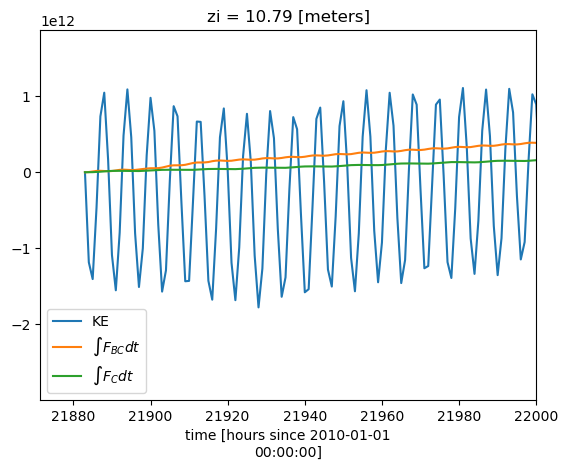

In [41]:
ybox = (0,80)
xbox = (0,250)


conversion_box = Conversion.sel(xb = slice(xbox[0],xbox[1]),yb = slice(ybox[0],ybox[1]))

KE_box = (KE_modal.sel(xb = slice(xbox[0],xbox[1]),yb = slice(ybox[0],ybox[1])).sum("mode").fillna(0).integrate("xb").integrate("yb") * 0.5e9).KE_modal ## Conversion for density and km2->m2
EF_box = (
    EF_alongbeam.EF_alongbeam.sel(xb = xbox[1],method = "nearest").sel(yb = slice(ybox[0],ybox[1])).integrate("yb")
    - EF_alongbeam.EF_alongbeam.sel(xb = xbox[0],method = "nearest").sel(yb = slice(ybox[0],ybox[1])).integrate("yb")
    - EF_acrossbeam.EF_acrossbeam.sel(yb = ybox[0],method = "nearest").sel(xb = slice(xbox[0],xbox[1])).integrate("xb")
    + EF_acrossbeam.EF_acrossbeam.sel(yb = ybox[1],method = "nearest").sel(xb = slice(xbox[0],xbox[1])).integrate("xb")
) * 1000 # conversion from km -> m


(KE_box - KE_box.isel(time = 0)).plot(label = "KE")

(EF_box.cumsum("time").sum("mode") * 3600).plot(label = r"$\int F_{BC} dt$")

(conversion_box.fillna(0).integrate("xb").integrate("yb").cumsum("time") * 1e6 * 3600).plot(label = r"$\int F_{C} dt$")

plt.xlim(None,22000)
plt.legend()

In [ ]:
total_sources = conversion_box.fillna(0).integrate("xb").integrate("yb").integrate("time") * 1e6 * 3600


print("Total Sources: ", EF_box.integrate("time").sum("mode").values + conversion_box.integrate("xb"))

Total Sources:  205893216.91870466


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 326.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'BT to BC Conversion')

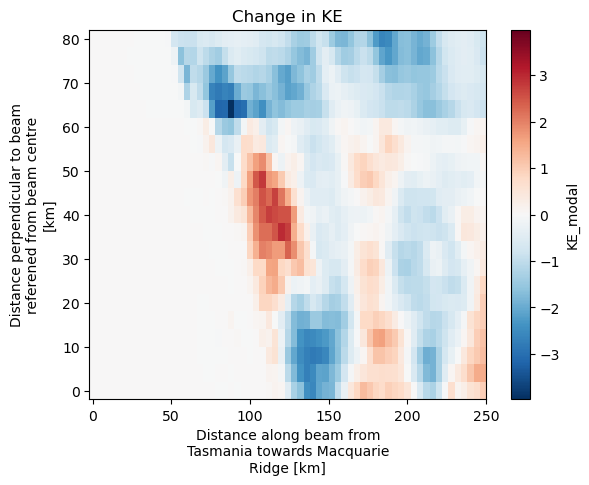

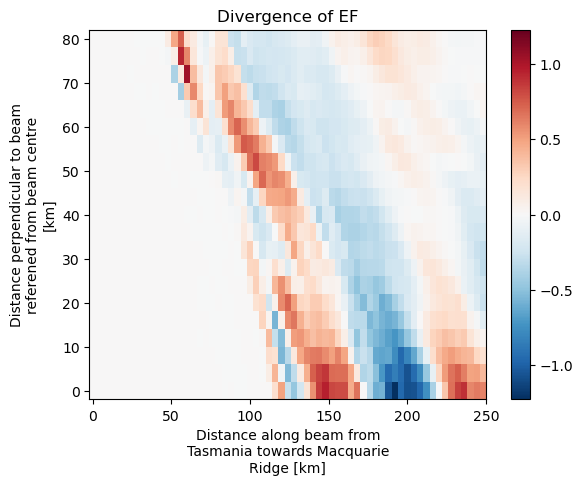

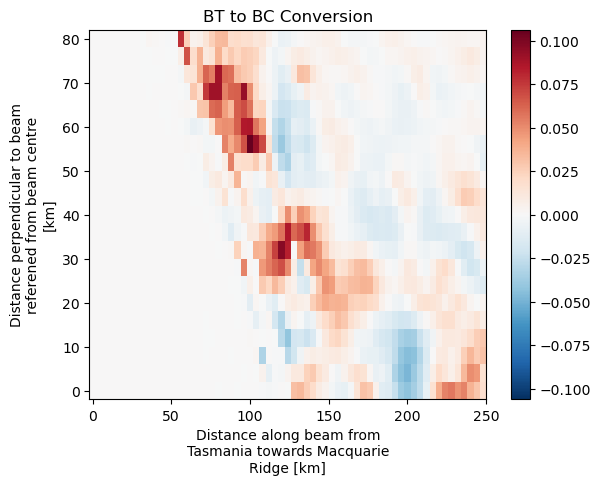

In [46]:
ybox = (0,80)
xbox = (0,250)

KE_box = KE_modal.sel(xb = slice(xbox[0],xbox[1]),yb = slice(ybox[0],ybox[1])).sum("mode")
(KE_box.isel(time = -1) - KE_box.isel(time = 0)).KE_modal.plot()

EF_box = (EF_alongbeam.EF_alongbeam - EF_acrossbeam.EF_acrossbeam).sel(xb = slice(xbox[0],xbox[1]),yb = slice(ybox[0],ybox[1])).sum("mode")

div_EF_box = (EF_box.differentiate("xb") + EF_box.differentiate("yb")) * 1e-3
plt.title("Change in KE")

plt.figure()
div_EF_box.integrate("time").plot()
plt.title("Divergence of EF")

plt.figure()
conversion_box.integrate("time").plot()
plt.title("BT to BC Conversion")

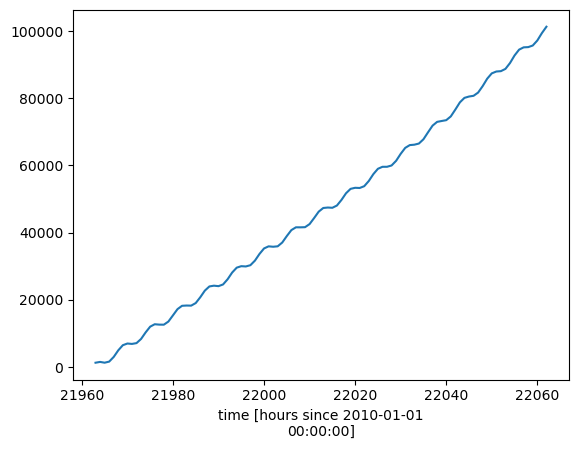

In [47]:
EF_box.sum("mode").isel(time = slice(80,180)).cumsum("time").plot()